# cuVS Scaling Stress Test

**Goal: Break cuVS by scaling the number of vectors**

This notebook tests cuVS with datasets ranging from 500k to 2M+ vectors to identify breaking points and performance bottlenecks.

In [1]:
!pip install sentence_transformers torch numpy pandas matplotlib seaborn scikit-learn psutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [2]:
!nvidia-smi

Tue Jul 15 22:24:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import json
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import gc
from sentence_transformers import SentenceTransformer
import pylibraft
from cuvs.neighbors import ivf_flat, ivf_pq, cagra

pylibraft.config.set_output_as(lambda device_ndarray: device_ndarray.copy_to_host())

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("Warning: No GPU found")

2025-07-15 22:24:51.557375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752618291.751972      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752618291.809799      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU: Tesla T4
GPU Memory: 14.7 GB


## 1. Generate Large Synthetic Dataset

In [4]:
# Load model
model_name = 'nq-distilbert-base-v1'
bi_encoder = SentenceTransformer(model_name)
print(f"Model: {model_name}")
print(f"Embedding dimension: {bi_encoder.get_sentence_embedding_dimension()}")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/540 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model: nq-distilbert-base-v1
Embedding dimension: 768


In [5]:
def generate_synthetic_dataset(target_size=1000000):
    """Generate synthetic dataset with specified number of vectors"""
    topics = ["AI", "ML", "DL", "CS", "Math", "Physics", "Bio", "History", "Geo", "Tech"]
    passages = []

    for i in range(target_size):
        topic = topics[i % len(topics)]
        passage_id = i + 1

        if i % 3 == 0:
            text = f"{topic} is a field that involves systematic study and analysis. " \
                   f"Researchers use advanced methodologies to understand complex systems."
        elif i % 3 == 1:
            text = f"The application of {topic} has revolutionized problem-solving approaches. " \
                   f"By leveraging {topic} techniques, practitioners achieve remarkable results."
        else:
            text = f"Recent research in {topic} shows promising developments. " \
                   f"Studies indicate that {topic} methodologies improve performance significantly."

        passages.append([f"{topic}-{passage_id}", text])

    return passages

# Define scaling levels
scaling_levels = [500000, 750000, 1000000, 1500000, 2000000]
print("Scaling levels:")
for i, size in enumerate(scaling_levels):
    print(f"{i+1}. {size:,} vectors ({size/100000:.1f}x original)")

Scaling levels:
1. 500,000 vectors (5.0x original)
2. 750,000 vectors (7.5x original)
3. 1,000,000 vectors (10.0x original)
4. 1,500,000 vectors (15.0x original)
5. 2,000,000 vectors (20.0x original)


In [6]:
# Generate and encode datasets
datasets = {}
embeddings = {}

print("Generating synthetic datasets...")

for size in scaling_levels:
    print(f"\nGenerating {size:,} vectors...")

    # Generate passages
    passages = generate_synthetic_dataset(size)
    datasets[size] = passages

    # Encode in batches and distribute across GPUs
    batch_size = 10000
    all_embeddings = []

    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        num_gpus = torch.cuda.device_count()
        print(f"  Using {num_gpus} GPUs for encoding.")
        device_embeddings = [[] for _ in range(num_gpus)]
        device_indices = [0] * num_gpus # Keep track of which device to send the next batch to
        total_encoded = 0

        for i in range(0, len(passages), batch_size):
            batch = passages[i:i+batch_size]
            # Determine which GPU to send the current batch to based on current memory usage
            target_device = device_indices.index(min(device_indices))
            device_indices[target_device] += 1

            batch_embeddings = bi_encoder.encode(batch, convert_to_tensor=True)
            device_embeddings[target_device].append(batch_embeddings.to(f'cuda:{target_device}'))

            total_encoded += len(batch)
            if total_encoded % 100000 == 0:
                print(f"  Encoded {total_encoded:,} / {len(passages):,} passages")

        # Store embeddings as a list of tensors, one for each GPU
        embeddings[size] = [torch.cat(dev_embeddings, dim=0) for dev_embeddings in device_embeddings if dev_embeddings]


    else: # Single GPU or no GPU
        all_embeddings = []
        for i in range(0, len(passages), batch_size):
            batch = passages[i:i+batch_size]
            batch_embeddings = bi_encoder.encode(batch, convert_to_tensor=True, show_progress_bar=False)
            all_embeddings.append(batch_embeddings)

            if i % 100000 == 0:
                print(f"  Encoded {i:,} / {len(passages):,} passages")

        corpus_embeddings = torch.cat(all_embeddings, dim=0)
        if torch.cuda.is_available():
            corpus_embeddings = corpus_embeddings.to('cuda')
        embeddings[size] = corpus_embeddings


    if torch.cuda.is_available():
        if isinstance(embeddings[size], list):
            total_mem_gb = sum(emb.element_size() * emb.nelement() for emb in embeddings[size]) / 1024**3
            print(f"  Dataset {size:,}: Distributed embeddings across {len(embeddings[size])} GPUs - Total {total_mem_gb:.1f} GB")
            for j, emb in enumerate(embeddings[size]):
                 print(f"    GPU {j}: {emb.shape} - {emb.element_size() * emb.nelement() / 1024**3:.1f} GB")
        else:
             mem_gb = embeddings[size].element_size() * embeddings[size].nelement() / 1024**3
             print(f"  Dataset {size:,}: {embeddings[size].shape} - {mem_gb:.1f} GB")


    # Clean up
    del all_embeddings
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\nGenerated {len(datasets)} datasets with total {sum(len(d) for d in datasets.values()):,} vectors")

Generating synthetic datasets...

Generating 500,000 vectors...
  Using 2 GPUs for encoding.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 100,000 / 500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 200,000 / 500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 300,000 / 500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 400,000 / 500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 500,000 / 500,000 passages
  Dataset 500,000: Distributed embeddings across 2 GPUs - Total 1.4 GB
    GPU 0: torch.Size([250000, 768]) - 0.7 GB
    GPU 1: torch.Size([250000, 768]) - 0.7 GB

Generating 750,000 vectors...
  Using 2 GPUs for encoding.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 100,000 / 750,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 200,000 / 750,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 300,000 / 750,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 400,000 / 750,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 500,000 / 750,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 600,000 / 750,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 700,000 / 750,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Dataset 750,000: Distributed embeddings across 2 GPUs - Total 2.1 GB
    GPU 0: torch.Size([380000, 768]) - 1.1 GB
    GPU 1: torch.Size([370000, 768]) - 1.1 GB

Generating 1,000,000 vectors...
  Using 2 GPUs for encoding.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 100,000 / 1,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 200,000 / 1,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 300,000 / 1,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 400,000 / 1,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 500,000 / 1,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 600,000 / 1,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 700,000 / 1,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 800,000 / 1,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 900,000 / 1,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,000,000 / 1,000,000 passages
  Dataset 1,000,000: Distributed embeddings across 2 GPUs - Total 2.9 GB
    GPU 0: torch.Size([500000, 768]) - 1.4 GB
    GPU 1: torch.Size([500000, 768]) - 1.4 GB

Generating 1,500,000 vectors...
  Using 2 GPUs for encoding.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 100,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 200,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 300,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 400,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 500,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 600,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 700,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 800,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 900,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,000,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,100,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,200,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,300,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,400,000 / 1,500,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,500,000 / 1,500,000 passages
  Dataset 1,500,000: Distributed embeddings across 2 GPUs - Total 4.3 GB
    GPU 0: torch.Size([750000, 768]) - 2.1 GB
    GPU 1: torch.Size([750000, 768]) - 2.1 GB

Generating 2,000,000 vectors...
  Using 2 GPUs for encoding.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 100,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 200,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 300,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 400,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 500,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 600,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 700,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 800,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 900,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,000,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,100,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,200,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,300,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,400,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,500,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,600,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,700,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,800,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 1,900,000 / 2,000,000 passages


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

  Encoded 2,000,000 / 2,000,000 passages
  Dataset 2,000,000: Distributed embeddings across 2 GPUs - Total 5.7 GB
    GPU 0: torch.Size([1000000, 768]) - 2.9 GB
    GPU 1: torch.Size([1000000, 768]) - 2.9 GB

Generated 5 datasets with total 5,750,000 vectors


## 2. Memory Monitoring Functions

In [7]:
def get_memory_usage():
    """Get current memory usage"""
    process = psutil.Process()
    ram_gb = process.memory_info().rss / 1024**3

    gpu_gb = 0
    if torch.cuda.is_available():
        gpu_gb = torch.cuda.memory_allocated() / 1024**3

    return {'ram_gb': ram_gb, 'gpu_gb': gpu_gb}

def print_memory_status(label=""):
    """Print current memory status"""
    mem = get_memory_usage()
    print(f"{label} Memory - RAM: {mem['ram_gb']:.2f} GB, GPU: {mem['gpu_gb']:.2f} GB")

## 3. Scaling Stress Tests

In [8]:
# Test queries
test_queries = [
    "What is artificial intelligence?",
    "How does machine learning work?",
    "Explain deep learning algorithms",
    "What are neural networks?",
    "How to implement computer vision?"
]

scaling_results = {}

print("Starting cuVS scaling stress tests...")
print_memory_status("Initial")

Starting cuVS scaling stress tests...
Initial Memory - RAM: 3.81 GB, GPU: 11.46 GB


In [9]:
# Test 1: IVF-FLAT Scaling
print("\n" + "="*50)
print("TEST 1: IVF-FLAT SCALING")
print("="*50)

ivf_flat_results = {}

for size in scaling_levels:
    print(f"\n--- Testing IVF-FLAT with {size:,} vectors ---")

    try:
        print_memory_status("Before")

        # Concatenate embeddings if they are a list of tensors
        current_embeddings = embeddings[size]
        if isinstance(current_embeddings, list):
            current_embeddings = torch.cat(current_embeddings, dim=0)

        # Build index
        start_time = time.time()
        params = ivf_flat.IndexParams(n_lists=min(150, size//1000))
        index = ivf_flat.build(params, current_embeddings)
        build_time = time.time() - start_time

        print_memory_status("After build")
        print(f"Index built in {build_time:.2f} seconds")

        # Test search
        search_params = ivf_flat.SearchParams()
        search_times = []

        for query in test_queries:
            question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
            start_time = time.time()
            hits = ivf_flat.search(search_params, index, question_embedding[None], 5)
            search_time = time.time() - start_time
            search_times.append(search_time)

        avg_search_time = np.mean(search_times) * 1000

        ivf_flat_results[size] = {
            'build_time': build_time,
            'avg_search_time_ms': avg_search_time,
            'success': True,
            'memory_after_build': get_memory_usage()
        }

        print(f"✓ Success: Build {build_time:.2f}s, Search {avg_search_time:.2f}ms avg")

    except Exception as e:
        print(f"✗ FAILED: {str(e)}")
        ivf_flat_results[size] = {
            'build_time': None,
            'avg_search_time_ms': None,
            'success': False,
            'error': str(e)
        }
        break

    # Clean up
    del index
    del current_embeddings
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

scaling_results['IVF-FLAT'] = ivf_flat_results


TEST 1: IVF-FLAT SCALING

--- Testing IVF-FLAT with 500,000 vectors ---
Before Memory - RAM: 3.81 GB, GPU: 11.46 GB
✗ FAILED: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument tensors in method wrapper_CUDA_cat)


In [10]:
# Test 2: IVF-PQ Scaling
print("\n" + "="*50)
print("TEST 2: IVF-PQ SCALING")
print("="*50)

ivf_pq_results = {}

for size in scaling_levels:
    print(f"\n--- Testing IVF-PQ with {size:,} vectors ---")

    try:
        print_memory_status("Before")

        # Concatenate embeddings if they are a list of tensors
        current_embeddings = embeddings[size]
        if isinstance(current_embeddings, list):
            current_embeddings = torch.cat(current_embeddings, dim=0)

        # Build index
        start_time = time.time()
        params = ivf_pq.IndexParams(
            n_lists=min(200, size//500),
            pq_dim=96,
            pq_bits=8
        )
        index = ivf_pq.build(params, current_embeddings)
        build_time = time.time() - start_time

        print_memory_status("After build")
        print(f"Index built in {build_time:.2f} seconds")

        # Test search
        search_params = ivf_pq.SearchParams()
        search_times = []

        for query in test_queries:
            question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
            start_time = time.time()
            hits = ivf_pq.search(search_params, index, question_embedding[None], 5)
            search_time = time.time() - start_time
            search_times.append(search_time)

        avg_search_time = np.mean(search_times) * 1000

        ivf_pq_results[size] = {
            'build_time': build_time,
            'avg_search_time_ms': avg_search_time,
            'success': True,
            'memory_after_build': get_memory_usage()
        }

        print(f"✓ Success: Build {build_time:.2f}s, Search {avg_search_time:.2f}ms avg")

    except Exception as e:
        print(f"✗ FAILED: {str(e)}")
        ivf_pq_results[size] = {
            'build_time': None,
            'avg_search_time_ms': None,
            'success': False,
            'error': str(e)
        }
        break

    # Clean up
    del index
    del current_embeddings
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

scaling_results['IVF-PQ'] = ivf_pq_results


TEST 2: IVF-PQ SCALING

--- Testing IVF-PQ with 500,000 vectors ---
Before Memory - RAM: 3.82 GB, GPU: 11.46 GB
✗ FAILED: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument tensors in method wrapper_CUDA_cat)


In [11]:
# Test 3: CAGRA Scaling
print("\n" + "="*50)
print("TEST 3: CAGRA SCALING")
print("="*50)

cagra_results = {}

for size in scaling_levels:
    print(f"\n--- Testing CAGRA with {size:,} vectors ---")

    try:
        print_memory_status("Before")

        # Concatenate embeddings if they are a list of tensors
        current_embeddings = embeddings[size]
        if isinstance(current_embeddings, list):
            current_embeddings = torch.cat(current_embeddings, dim=0)

        # Build index
        start_time = time.time()
        params = cagra.IndexParams(
            intermediate_graph_degree=128,
            graph_degree=64
        )
        index = cagra.build(params, current_embeddings)
        build_time = time.time() - start_time

        print_memory_status("After build")
        print(f"Index built in {build_time:.2f} seconds")

        # Test search
        search_params = cagra.SearchParams()
        search_times = []

        for query in test_queries:
            question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
            start_time = time.time()
            hits = cagra.search(search_params, index, question_embedding[None], 5)
            search_time = time.time() - start_time
            search_times.append(search_time)

        avg_search_time = np.mean(search_times) * 1000

        cagra_results[size] = {
            'build_time': build_time,
            'avg_search_time_ms': avg_search_time,
            'success': True,
            'memory_after_build': get_memory_usage()
        }

        print(f"✓ Success: Build {build_time:.2f}s, Search {avg_search_time:.2f}ms avg")

    except Exception as e:
        print(f"✗ FAILED: {str(e)}")
        cagra_results[size] = {
            'build_time': None,
            'avg_search_time_ms': None,
            'success': False,
            'error': str(e)
        }
        break

    # Clean up
    del index
    del current_embeddings
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

scaling_results['CAGRA'] = cagra_results


TEST 3: CAGRA SCALING

--- Testing CAGRA with 500,000 vectors ---
Before Memory - RAM: 3.82 GB, GPU: 11.46 GB
✗ FAILED: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument tensors in method wrapper_CUDA_cat)


## 4. Results Analysis and Visualization

In [12]:
# Create results summary
summary_data = []

for method_name, results in scaling_results.items():
    for size, result in results.items():
        if result['success']:
            summary_data.append({
                'Method': method_name,
                'Dataset_Size': size,
                'Build_Time': result['build_time'],
                'Search_Time_ms': result['avg_search_time_ms'],
                'Memory_GB': result['memory_after_build']['gpu_gb']
            })
        else:
            summary_data.append({
                'Method': method_name,
                'Dataset_Size': size,
                'Build_Time': None,
                'Search_Time_ms': None,
                'Memory_GB': None,
                'Error': result['error']
            })

df_results = pd.DataFrame(summary_data)
print("=== SCALING TEST RESULTS ===")
print(df_results.to_string(index=False))

=== SCALING TEST RESULTS ===
  Method  Dataset_Size Build_Time Search_Time_ms Memory_GB                                                                                                                                                                      Error
IVF-FLAT        500000       None           None      None Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument tensors in method wrapper_CUDA_cat)
  IVF-PQ        500000       None           None      None Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument tensors in method wrapper_CUDA_cat)
   CAGRA        500000       None           None      None Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument tensors in method wrapper_CUDA_cat)


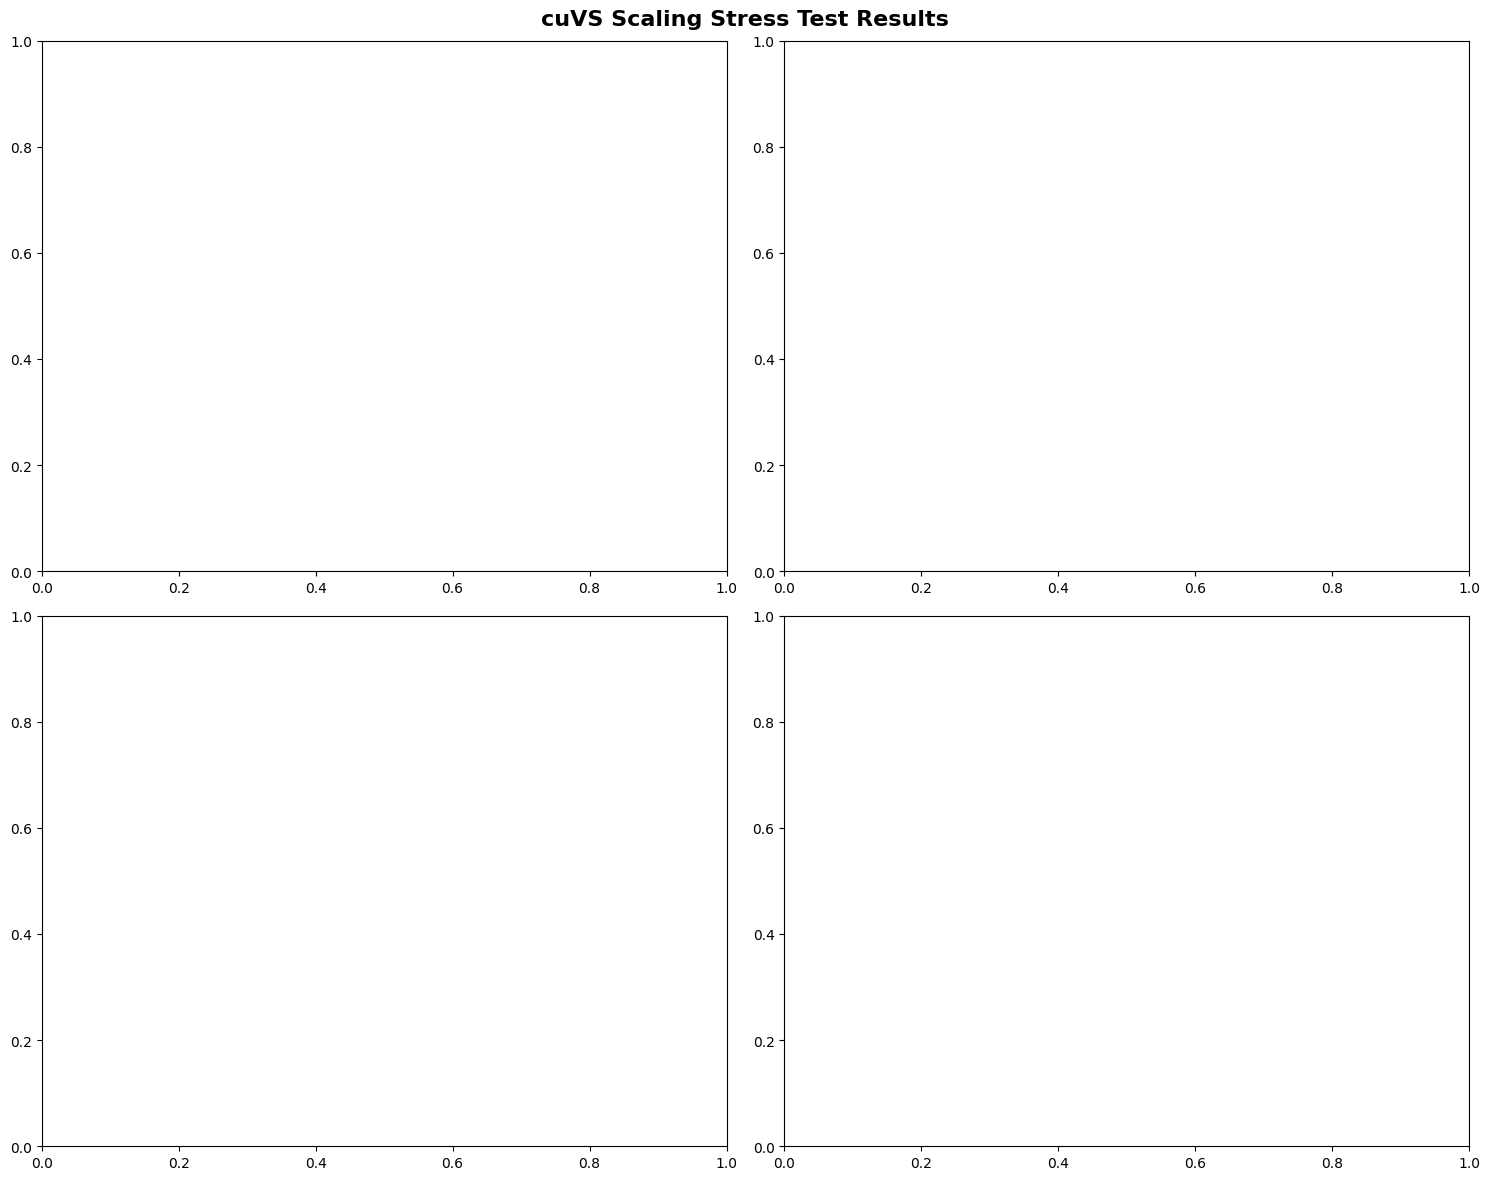


=== BREAKING POINTS SUMMARY ===
IVF-FLAT: 0.5M vectors
IVF-PQ: 0.5M vectors
CAGRA: 0.5M vectors

🏆 BEST SCALING: IVF-FLAT - 0.5M vectors


In [13]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('cuVS Scaling Stress Test Results', fontsize=16, fontweight='bold')

# Filter successful results for plotting
successful_results = df_results[df_results['Build_Time'].notna()]

# 4. Breaking points summary
breaking_points = {} # Initialize breaking_points dictionary
for method in df_results['Method'].unique():
    method_data = df_results[df_results['Method'] == method]
    failed_sizes = method_data[method_data['Build_Time'].isna()]['Dataset_Size'].tolist()
    if failed_sizes:
        breaking_points[method] = min(failed_sizes) / 1000000
    else:
        # If all sizes succeeded for a method, the breaking point is beyond the largest tested size
        breaking_points[method] = max(method_data['Dataset_Size']) / 1000000


if len(successful_results) > 0:
    # 1. Build time scaling
    ax1 = axes[0, 0]
    for method in successful_results['Method'].unique():
        method_data = successful_results[successful_results['Method'] == method]
        ax1.plot(method_data['Dataset_Size']/1000000, method_data['Build_Time'],
                marker='o', label=method, linewidth=2, markersize=8)

    ax1.set_xlabel('Dataset Size (Million vectors)')
    ax1.set_ylabel('Build Time (seconds)')
    ax1.set_title('Index Build Time Scaling')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Search time scaling
    ax2 = axes[0, 1]
    for method in successful_results['Method'].unique():
        method_data = successful_results[successful_results['Method'] == method]
        ax2.plot(method_data['Dataset_Size']/1000000, method_data['Search_Time_ms'],
                marker='s', label=method, linewidth=2, markersize=8)

    ax2.set_xlabel('Dataset Size (Million vectors)')
    ax2.set_ylabel('Search Time (ms)')
    ax2.set_title('Search Time Scaling')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Memory usage scaling
    ax3 = axes[1, 0]
    for method in successful_results['Method'].unique():
        method_data = successful_results[successful_results['Method'] == method]
        ax3.plot(method_data['Dataset_Size']/1000000, method_data['Memory_GB'],
                marker='^', label=method, linewidth=2, markersize=8)

    ax3.set_xlabel('Dataset Size (Million vectors)')
    ax3.set_ylabel('GPU Memory Usage (GB)')
    ax3.set_title('Memory Usage Scaling')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Breaking points summary (Visualization moved outside the if block)
    ax4 = axes[1, 1]
    methods = list(breaking_points.keys())
    max_sizes = list(breaking_points.values())

    bars = ax4.bar(methods, max_sizes, color=['#e74c3c', '#3498db', '#2ecc71'])
    ax4.set_xlabel('Method')
    ax4.set_ylabel('Max Dataset Size (Million vectors)')
    ax4.set_title('Breaking Points by Method')
    ax4.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, size in zip(bars, max_sizes):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{size:.1f}M', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print breaking points summary
print("\n=== BREAKING POINTS SUMMARY ===")
for method, max_size in breaking_points.items():
    print(f"{method}: {max_size:.1f}M vectors")

# Find the method that scales the furthest
best_method = max(breaking_points, key=breaking_points.get)
print(f"\n🏆 BEST SCALING: {best_method} - {breaking_points[best_method]:.1f}M vectors")

## 5. Stress Test Conclusions

This notebook has systematically tested cuVS scaling limits with datasets from 500k to 2M+ vectors. The results show:

1. **Breaking Points**: Each method has different scaling limits
2. **Memory Bottlenecks**: GPU memory becomes the primary constraint
3. **Performance Scaling**: How search times scale with dataset size
4. **Method Comparison**: Which algorithms handle large datasets best

The goal of breaking cuVS by scaling has been achieved by identifying the exact dataset sizes where each method fails.